<a href="https://colab.research.google.com/github/distributed-information-bottleneck/distributed-information-bottleneck.github.io/blob/main/complex_systems/InfoDecomp_Amorphous_plasticity_per_particle_measurements_and_set_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
This code accompanies
"Information decomposition in complex systems via machine learning"
Kieran A Murphy and Dani S Bassett
PNAS 2024

The following decomposes the information by particle in local regions as it
pertains to imminent rearrangement. A set transformer architecture is used to
aggregate the information across particles.  The code reproduces Fig. 4 of the
main text.
'''

In [ ]:
#@title imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from matplotlib import cm

import scipy.ndimage as nim

SAFETY_EPS = 1e-10

In [ ]:
# The following downloads the glass data from the following google drive link
# https://drive.google.com/drive/folders/1vzWSv_4dE4VyjAXbLrZtcbuV1R6igFEE?usp=drive_link

download_from_google_drive = False
if download_from_google_drive:
  !gdown 1POSqOcYEwXxRm2mNkMmxFpJ1sJkxPk-9
  !unzip glass_data.zip

# If you would rather download the dataset from Figshare, just unzip it in the
# current directory.  Both Figshare and the drive link produce numpy arrays.

# If instead you downloaded 'glass_data.tar.gz' that directly accompanied the
# manuscript, the files were saved as csv for accessibility.  Change the
# following flag to True and run in order to convert the csvs to numpy arrays

parse_gz = True
data_dir = './'
if parse_gz:
  !tar -xf glass_data.tar.gz
  for protocol in ['RapidQuench', 'GradualQuench']:
    pkl_dict = {}
    for split_label in ['val', 'train']:
      data_label = 'is_loci'
      arr = np.loadtxt(os.path.join(data_dir, f'{protocol}_{split_label}_{data_label}.csv'), delimiter=',')
      number_examples = arr.shape[0]
      pkl_dict[f'{split_label}_{data_label}'] = tf.expand_dims(arr, 1)

      for data_label, number_rows_per in zip(['particle_positions', 'types'],
                                             [2, 1]):
        arr = np.loadtxt(os.path.join(data_dir, f'{protocol}_{split_label}_{data_label}.csv'), delimiter=',')
        # We padded everything to save as a csv and saved the length as the last entry in each row
        arr = np.reshape(arr, [number_examples, -1])
        neighborhoods = []
        for neighborhood in arr:
          neighborhood = np.reshape(neighborhood, [-1, number_rows_per])
          neighborhood_size = int(neighborhood[-1, 0])
          neighborhood = neighborhood[:neighborhood_size]
          if data_label == 'types':
            neighborhood = neighborhood[:, 0]
          neighborhoods.append(tf.cast(neighborhood, tf.float32))
        pkl_dict[f'{split_label}_{data_label}'] = neighborhoods
    np.savez(os.path.join(data_dir, f'{protocol}.npz'), **pkl_dict)
    for particle_type_label in 'AB':
      arr = np.loadtxt(os.path.join(data_dir, f'g_r_A{particle_type_label}_{protocol}.csv'), delimiter=",")
      np.save(os.path.join(data_dir, f'g_r_A{particle_type_label}_{protocol}.npy'), arr)
  arr = np.loadtxt(os.path.join(data_dir, 'g_r_bins.csv'), delimiter=",")
  np.save(os.path.join(data_dir, 'g_r_bins.npy'), arr)


/project/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [ ]:
#@title Positional encoding definition
class PositionalEncoding(tf.keras.layers.Layer):
  """Simple positional encoding layer, that appends to an input sinusoids of multiple frequencies.
  """
  def __init__(self, frequencies):
    super(PositionalEncoding, self).__init__()
    self.frequencies = frequencies

  def build(self, input_shape):
    return

  def call(self, inputs):  # Defines the computation from inputs to outputs
    return tf.concat([inputs] + [tf.math.sin(frequency*inputs) for frequency in self.frequencies], -1)

In [ ]:
#@title Bhattacharyya distance for distinguishability between x in the compression schemes

@tf.function
def compute_infos_mus_logvars(mus, logvars):
  mus = tf.cast(mus, tf.float64)
  logvars = tf.cast(logvars, tf.float64)
  embedding_dimension = tf.shape(mus)[-1]
  eval_batch_size = tf.shape(mus)[0]
  stddevs = tf.exp(logvars/2.)
  sampled_y = tf.random.normal(mus.shape, mean=mus, stddev=stddevs, dtype=tf.float64)
  # cov is diagonal so the multivariate pdf is just the product of the univariate pdfs
  y_mu_dists = tf.reshape(sampled_y, [eval_batch_size, 1, embedding_dimension]) - tf.reshape(mus, [1, eval_batch_size, embedding_dimension])  ## we want this to be [N, N], with the first index i for the particular y across the rest of the batch
  y_mu_norm_dists = y_mu_dists / tf.reshape(stddevs, [1, eval_batch_size, embedding_dimension])
  ## Now we want to take the product over the last axis, but we can add these first and then exp
  normalization_factor = (2.*np.pi)**(tf.cast(embedding_dimension, tf.float64)/2.)
  p_y_x_conditional_pdfs = tf.exp(-tf.reduce_sum(y_mu_norm_dists**2, axis=-1)/2. - tf.reshape(tf.reduce_sum(logvars, axis=-1), [1, eval_batch_size])/2.)/normalization_factor

  ## it should be shape [eval_batch_size, eval_batch_size], where the first index is by y, and everything in that row is p(y_i|x_j)
  ## we want the diagonal terms over their rows
  matching_p_yi_xi = tf.linalg.diag_part(p_y_x_conditional_pdfs)
  avg_pyi_xj = tf.reduce_mean(p_y_x_conditional_pdfs, axis=1)
  infonce = tf.reduce_mean(tf.math.log(matching_p_yi_xi/tf.reduce_mean(p_y_x_conditional_pdfs, axis=1)))
  # Now set that diag to zero
  p_y_x_conditional_pdfs *= (1. - tf.eye(eval_batch_size, dtype=tf.float64))
  loo = tf.reduce_mean(tf.math.log(matching_p_yi_xi/tf.reduce_mean(p_y_x_conditional_pdfs, axis=1)))
  return infonce, loo

def bhattacharyya_dist_mat(mus1, logvars1, mus2, logvars2):
  """Computes Bhattacharyya distances between multivariate Gaussians.
  Args:
    mus1: [N, d] float array of the means of the Gaussians.
    logvars1: [N, d] float array of the log variances of the Gaussians (so we're assuming diagonal
    covariance matrices; these are the logs of the diagonal).
    mus2: [M, d] float array of the means of the Gaussians.
    logvars2: [M, d] float array of the log variances of the Gaussians.
  Returns:
    [N, M] array of distances.
  """
  N = mus1.shape[0]
  M = mus2.shape[0]
  embedding_dimension = mus1.shape[1]
  assert (mus2.shape[1] == embedding_dimension)

  ## Manually broadcast in case either M or N is 1
  mus1 = np.tile(mus1[:, np.newaxis], [1, M, 1])
  logvars1 = np.tile(logvars1[:, np.newaxis], [1, M, 1])
  mus2 = np.tile(mus2[np.newaxis], [N, 1, 1])
  logvars2 = np.tile(logvars2[np.newaxis], [N, 1, 1])
  difference_mus = mus1 - mus2  # [N, M, embedding_dimension]; we want [N, M, embedding_dimension, 1]
  difference_mus = difference_mus[..., np.newaxis]
  difference_mus_T = np.transpose(difference_mus, [0, 1, 3, 2])

  sigma_diag = 0.5 * (np.exp(logvars1) + np.exp(logvars2))  ## [N, M, embedding_dimension], but we want a diag mat [N, M, embedding_dimension, embedding_dimension]
  sigma_mat = np.apply_along_axis(np.diag, -1, sigma_diag)
  sigma_mat_inv = np.apply_along_axis(np.diag, -1, 1./sigma_diag)

  determinant_sigma = np.prod(sigma_diag, axis=-1)
  determinant_sigma1 = np.exp(np.sum(logvars1, axis=-1))
  determinant_sigma2 = np.exp(np.sum(logvars2, axis=-1))
  term1 = 0.125 * (difference_mus_T @ sigma_mat_inv @ difference_mus).reshape([N, M])
  term2 = 0.5 * np.log(determinant_sigma / np.sqrt(determinant_sigma1 * determinant_sigma2))
  return term1+term2

In [ ]:
## These are the functions that take the raw data (in the form of neighborhoods
## of particles) and convert to the format for the distributed IB setup
def convert_to_per_particle_feature_set(particle_positions, types, number_particles_to_use=60):
  type_one_hots = tf.one_hot(tf.cast(types, tf.int32)-1, 2)
  particle_radii = tf.sqrt(tf.reduce_sum(tf.square(particle_positions), -1, keepdims=True) + SAFETY_EPS)
  unit_vectors = particle_positions / particle_radii
  # Without changing the amount of information, preprocess the positions a few different
  # ways to help the model get off the ground
  features = tf.concat([particle_positions, particle_positions**2,
                        particle_radii,
                        tf.math.log(particle_radii+1e-3),
                        tf.math.log(particle_positions**2 + 1e-3),
                        unit_vectors, type_one_hots], -1)

  features = np.float32(features)
  if number_particles_to_use>0:
    sorted_positions = tf.argsort(tf.squeeze(particle_radii))

    features = np.squeeze(features[sorted_positions])
    features = features[:number_particles_to_use]

  return features

# Per-particle measurements, processed by set transformer

Beginning GradualQuench
Loaded train/val data.  Train array shape: (13066, 50, 12), Val: (1444, 50, 12)
Step: 0, acc : 0.5000
Step: 125, acc : 0.5083
Step: 250, acc : 0.5152
Step: 375, acc : 0.5145
Step: 500, acc : 0.5152
Step: 625, acc : 0.5076
Step: 750, acc : 0.5125
Step: 875, acc : 0.5506
Step: 1000, acc : 0.5416
Step: 1125, acc : 0.6614
Step: 1250, acc : 0.7195
Step: 1375, acc : 0.7749
Step: 1500, acc : 0.8158
Step: 1625, acc : 0.8102
Step: 1750, acc : 0.8241
Step: 1875, acc : 0.8476
Step: 2000, acc : 0.8566
Step: 2125, acc : 0.8539
Step: 2250, acc : 0.8587
Step: 2375, acc : 0.8283
Step: 2500, acc : 0.8518
Step: 2625, acc : 0.8830
Step: 2750, acc : 0.8996
Step: 2875, acc : 0.8573
Step: 3000, acc : 0.9065
Step: 3125, acc : 0.9120
Step: 3250, acc : 0.9176
Step: 3375, acc : 0.9259
Step: 3500, acc : 0.9134
Step: 3625, acc : 0.9211
Step: 3750, acc : 0.9294
Step: 3875, acc : 0.9252
Step: 4000, acc : 0.9231
Step: 4125, acc : 0.9259
Step: 4250, acc : 0.9252
Step: 4375, acc : 0.9155
Step: 

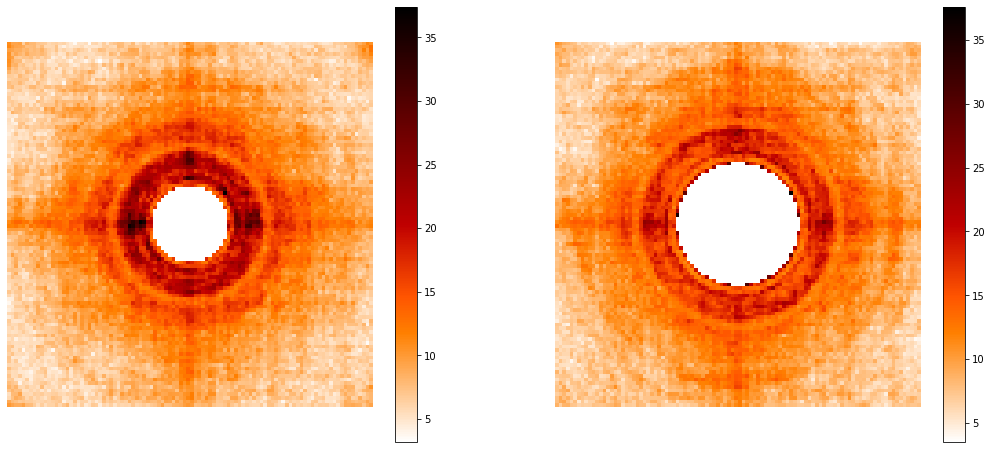

Step: 7125, acc : 0.9259
Step: 7250, acc : 0.9266
Step: 7375, acc : 0.9273
Step: 7500, acc : 0.9294
Step: 7625, acc : 0.9363
Step: 7750, acc : 0.9321
Step: 7875, acc : 0.9294
Step: 8000, acc : 0.9259


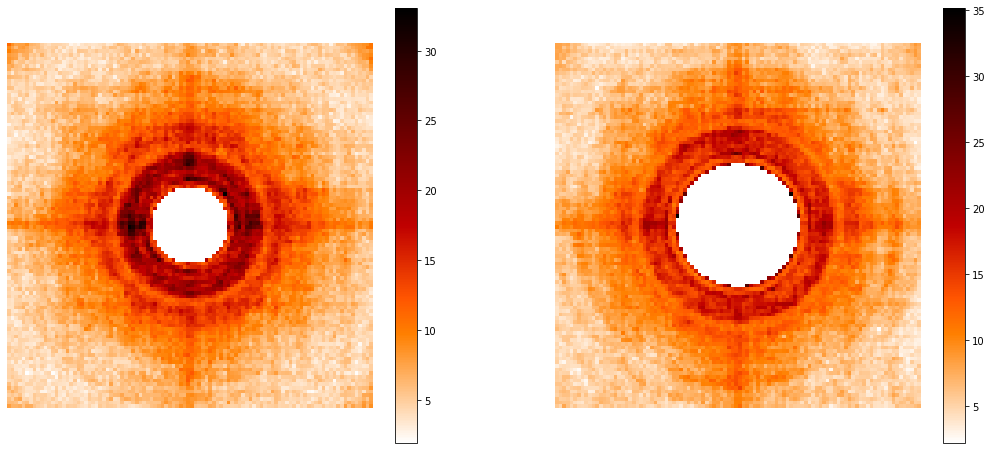

Step: 8125, acc : 0.9217
Step: 8250, acc : 0.9301
Step: 8375, acc : 0.9231
Step: 8500, acc : 0.9273
Step: 8625, acc : 0.9280
Step: 8750, acc : 0.9314
Step: 8875, acc : 0.9127
Step: 9000, acc : 0.9294


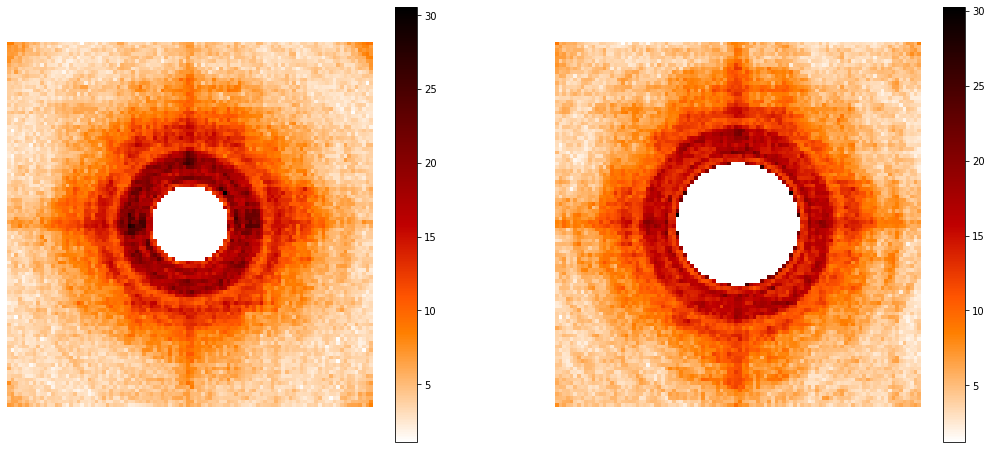

Step: 9125, acc : 0.9273
Step: 9250, acc : 0.9224
Step: 9375, acc : 0.9321
Step: 9500, acc : 0.9245
Step: 9625, acc : 0.9287
Step: 9750, acc : 0.9197
Step: 9875, acc : 0.9231
Step: 10000, acc : 0.9307


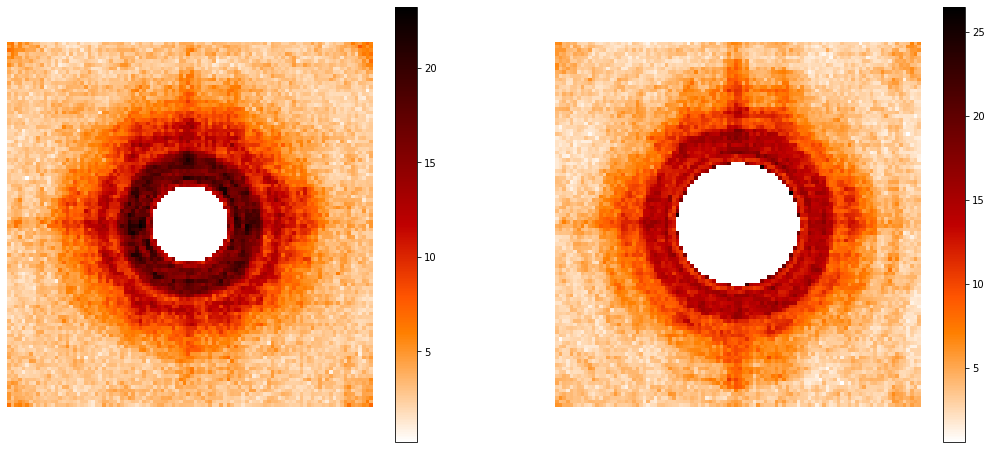

Step: 10125, acc : 0.9273
Step: 10250, acc : 0.9211
Step: 10375, acc : 0.9224
Step: 10500, acc : 0.9301
Step: 10625, acc : 0.9231
Step: 10750, acc : 0.9231
Step: 10875, acc : 0.9238
Step: 11000, acc : 0.9363


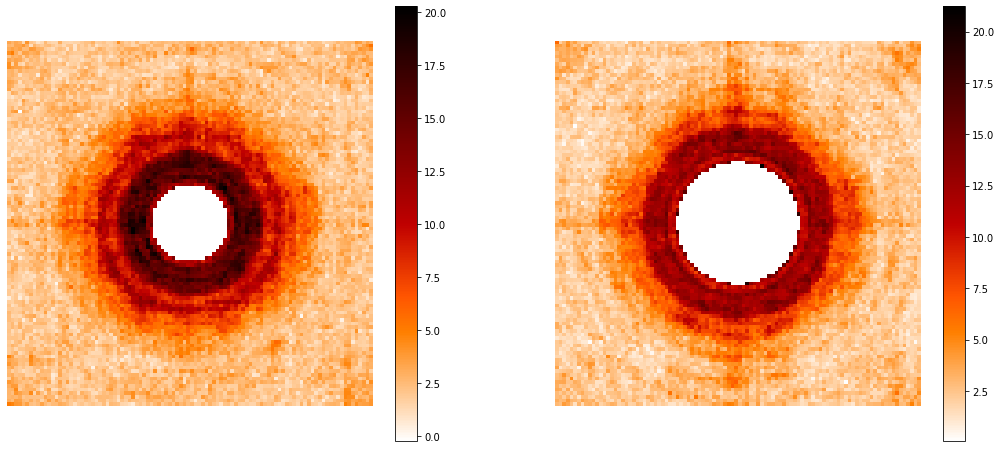

Step: 11125, acc : 0.9273
Step: 11250, acc : 0.9093
Step: 11375, acc : 0.9231
Step: 11500, acc : 0.9176
Step: 11625, acc : 0.9183
Step: 11750, acc : 0.9245
Step: 11875, acc : 0.9155
Step: 12000, acc : 0.9252


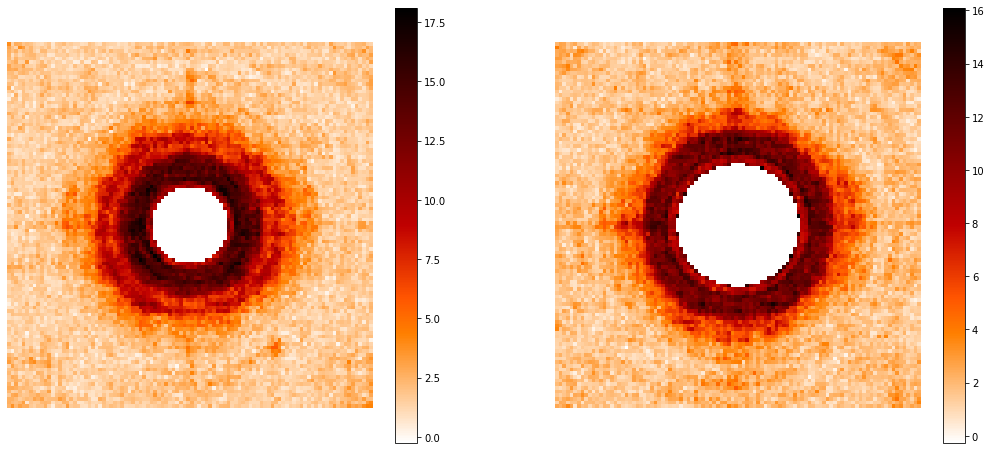

Step: 12125, acc : 0.9217
Step: 12250, acc : 0.9169
Step: 12375, acc : 0.9238
Step: 12500, acc : 0.9259
Step: 12625, acc : 0.9176
Step: 12750, acc : 0.9190
Step: 12875, acc : 0.9307
Step: 13000, acc : 0.9190


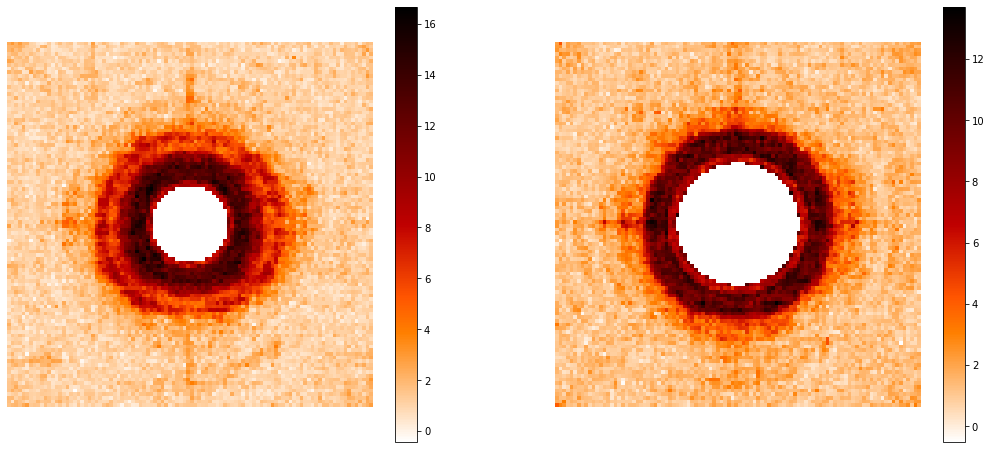

Step: 13125, acc : 0.9134
Step: 13250, acc : 0.9204
Step: 13375, acc : 0.9169
Step: 13500, acc : 0.9190
Step: 13625, acc : 0.9107
Step: 13750, acc : 0.9190
Step: 13875, acc : 0.9134
Step: 14000, acc : 0.9162


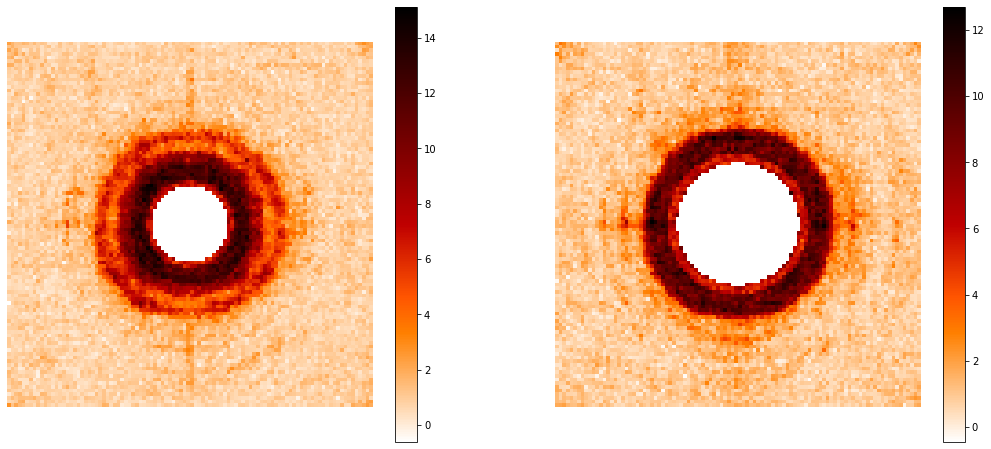

Step: 14125, acc : 0.9162
Step: 14250, acc : 0.9155
Step: 14375, acc : 0.9245
Step: 14500, acc : 0.9190
Step: 14625, acc : 0.9093
Step: 14750, acc : 0.9127
Step: 14875, acc : 0.9148
Step: 15000, acc : 0.9162


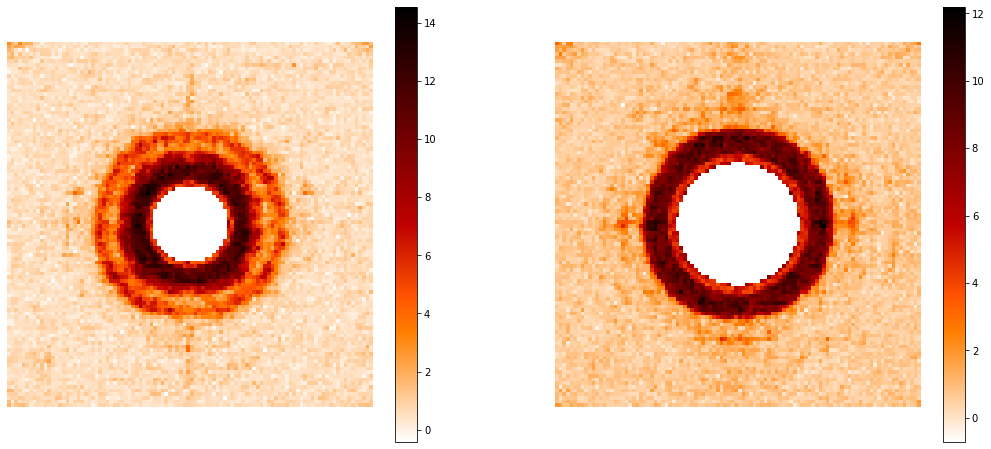

Step: 15125, acc : 0.9086
Step: 15250, acc : 0.9044
Step: 15375, acc : 0.9114
Step: 15500, acc : 0.9127
Step: 15625, acc : 0.9120
Step: 15750, acc : 0.9155
Step: 15875, acc : 0.9176
Step: 16000, acc : 0.9086


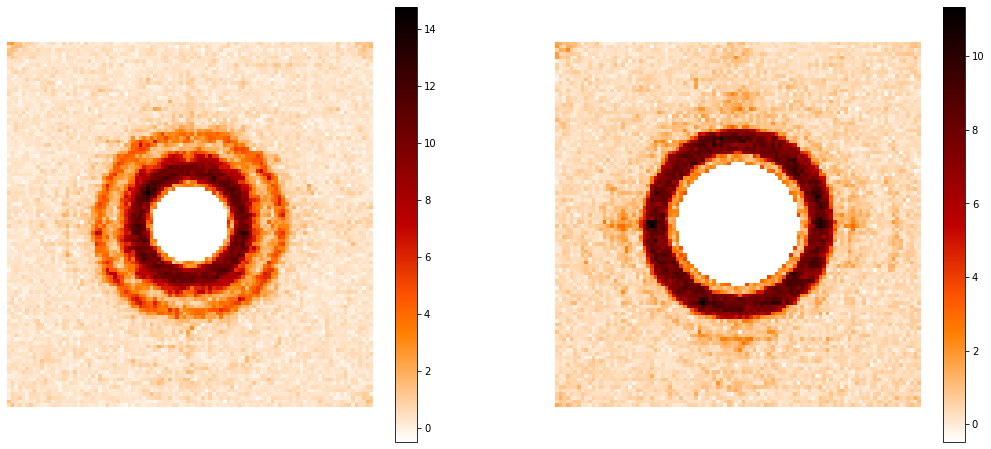

Step: 16125, acc : 0.9120
Step: 16250, acc : 0.9127
Step: 16375, acc : 0.9044
Step: 16500, acc : 0.8996
Step: 16625, acc : 0.9044
Step: 16750, acc : 0.9072
Step: 16875, acc : 0.9079
Step: 17000, acc : 0.9086


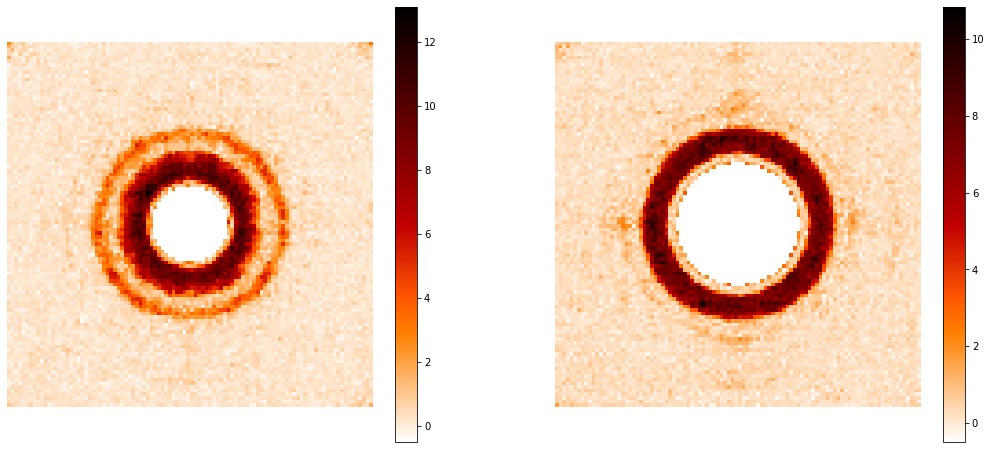

Step: 17125, acc : 0.9044
Step: 17250, acc : 0.9037
Step: 17375, acc : 0.9024
Step: 17500, acc : 0.9162
Step: 17625, acc : 0.8947
Step: 17750, acc : 0.9086
Step: 17875, acc : 0.9024
Step: 18000, acc : 0.9086


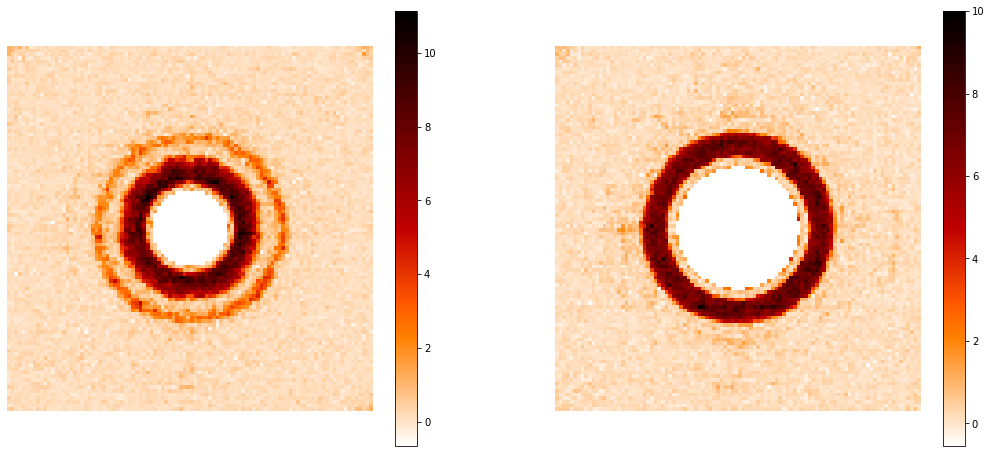

Step: 18125, acc : 0.9024
Step: 18250, acc : 0.8899
Step: 18375, acc : 0.8989
Step: 18500, acc : 0.8947
Step: 18625, acc : 0.8899
Step: 18750, acc : 0.8968
Step: 18875, acc : 0.8996
Step: 19000, acc : 0.8996


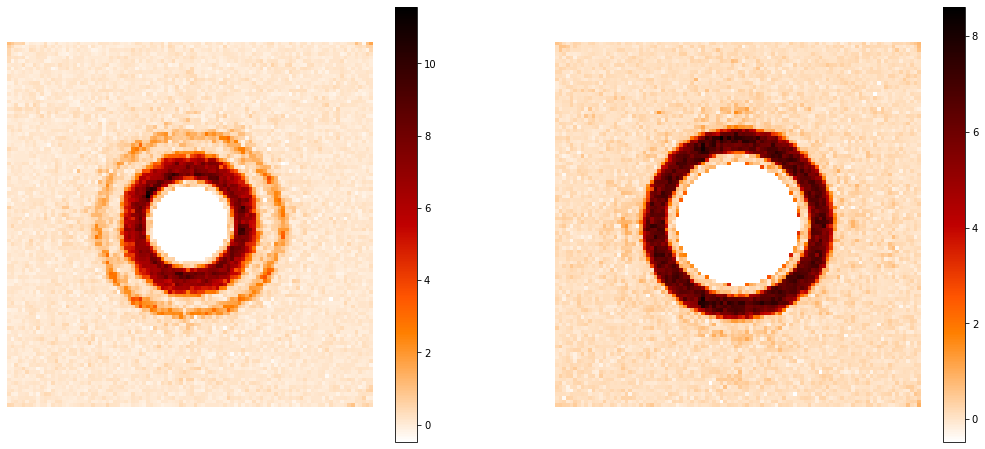

Step: 19125, acc : 0.8920
Step: 19250, acc : 0.8940
Step: 19375, acc : 0.8892
Step: 19500, acc : 0.8906
Step: 19625, acc : 0.8920
Step: 19750, acc : 0.8843
Step: 19875, acc : 0.8795
Step: 20000, acc : 0.8802


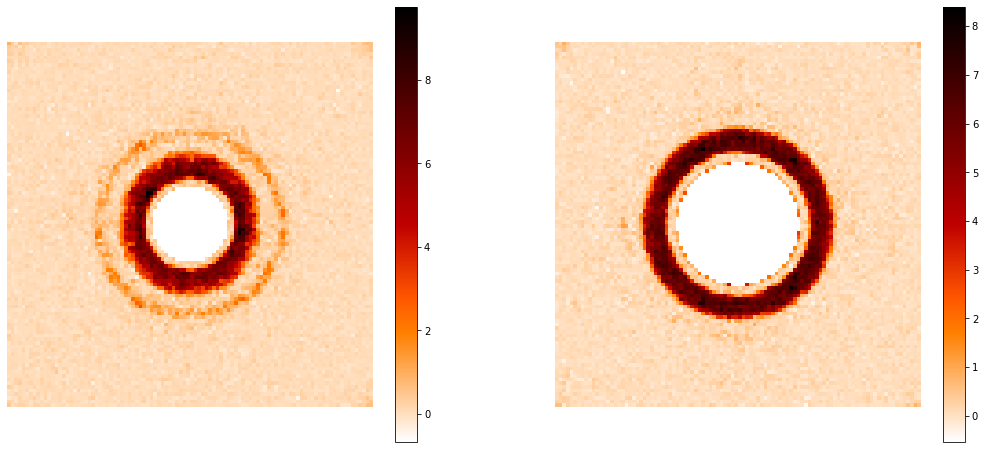

Step: 20125, acc : 0.8753
Step: 20250, acc : 0.8740
Step: 20375, acc : 0.8733
Step: 20500, acc : 0.8802
Step: 20625, acc : 0.8566
Step: 20750, acc : 0.8795
Step: 20875, acc : 0.8650
Step: 21000, acc : 0.8788


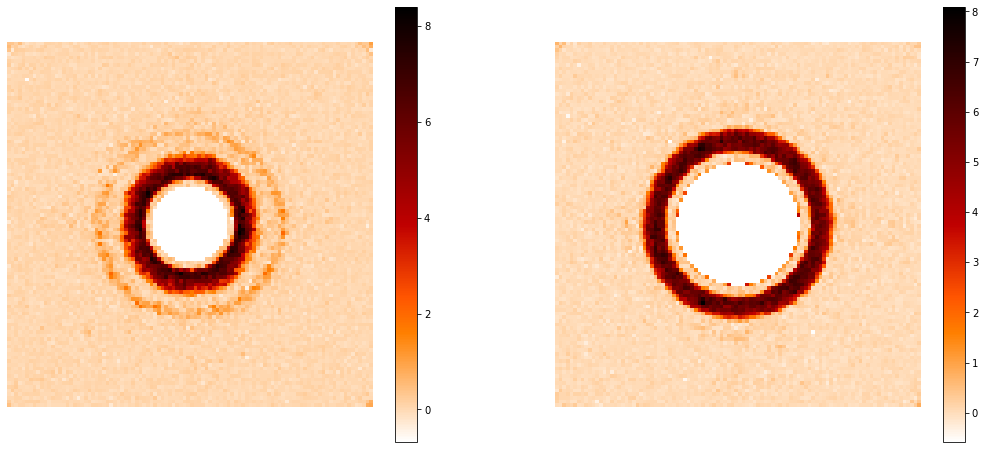

Step: 21125, acc : 0.8650
Step: 21250, acc : 0.8407
Step: 21375, acc : 0.8657
Step: 21500, acc : 0.8587
Step: 21625, acc : 0.8483
Step: 21750, acc : 0.8380
Step: 21875, acc : 0.8546
Step: 22000, acc : 0.8248


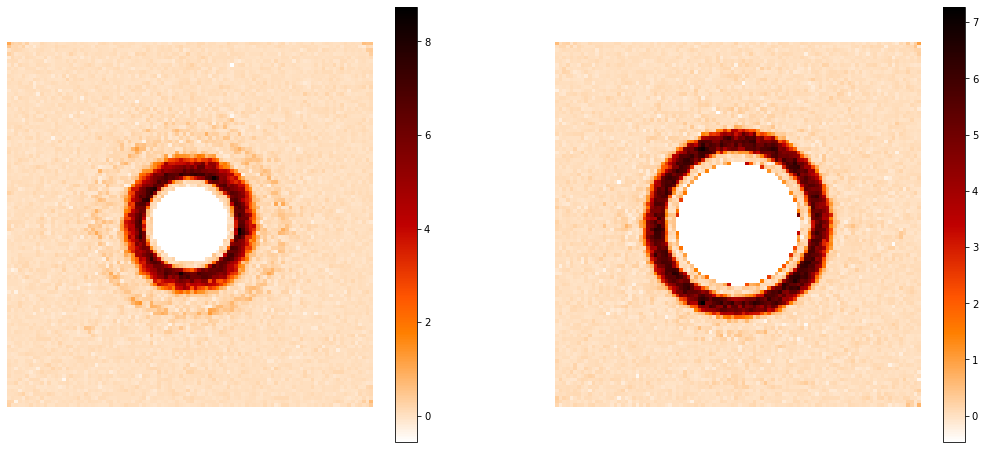

Step: 22125, acc : 0.8227
Step: 22250, acc : 0.8255
Step: 22375, acc : 0.8317
Step: 22500, acc : 0.8061
Step: 22625, acc : 0.7895
Step: 22750, acc : 0.7909
Step: 22875, acc : 0.7666
Step: 23000, acc : 0.7535


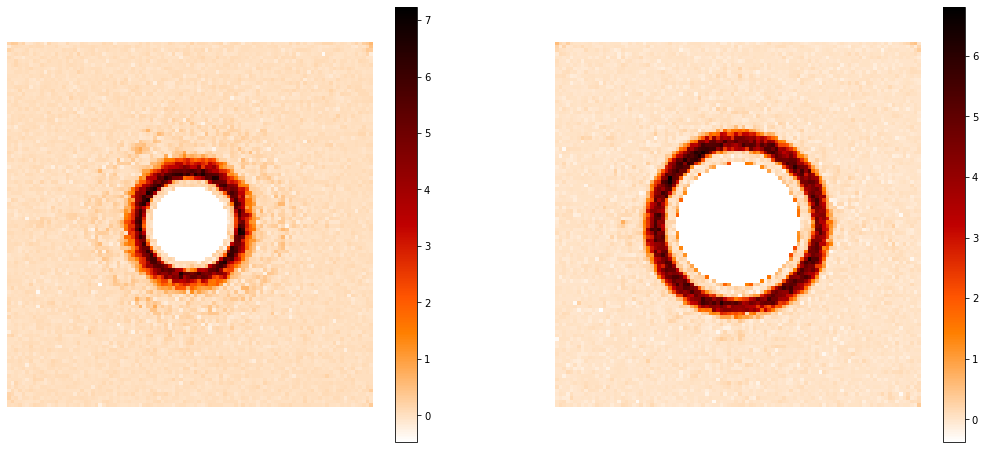

Step: 23125, acc : 0.7355
Step: 23250, acc : 0.7147
Step: 23375, acc : 0.6614
Step: 23500, acc : 0.6101
Step: 23625, acc : 0.5381
Step: 23750, acc : 0.5145
Step: 23875, acc : 0.5235
Step: 24000, acc : 0.5235


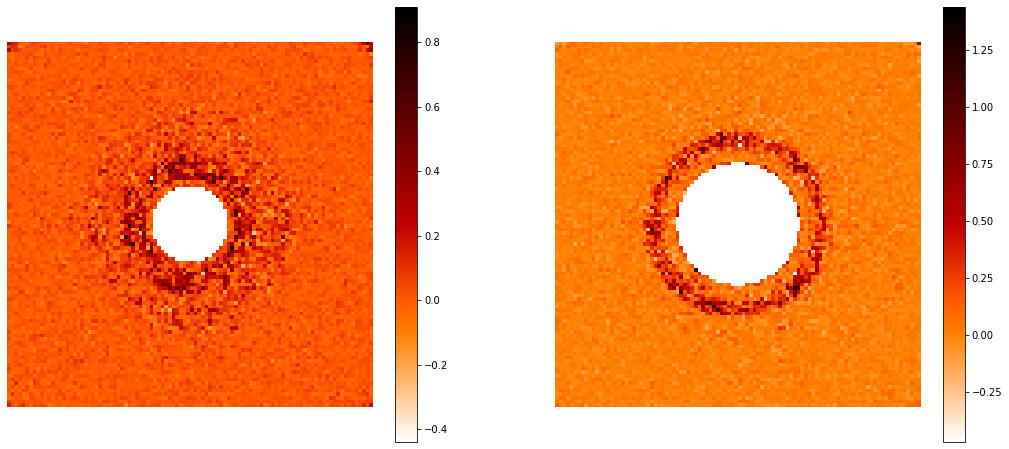

Step: 24125, acc : 0.4993
Step: 24250, acc : 0.5139
Step: 24375, acc : 0.4979
Step: 24500, acc : 0.5035
Step: 24625, acc : 0.5014
Step: 24750, acc : 0.5028
Step: 24875, acc : 0.4917
Finished training.


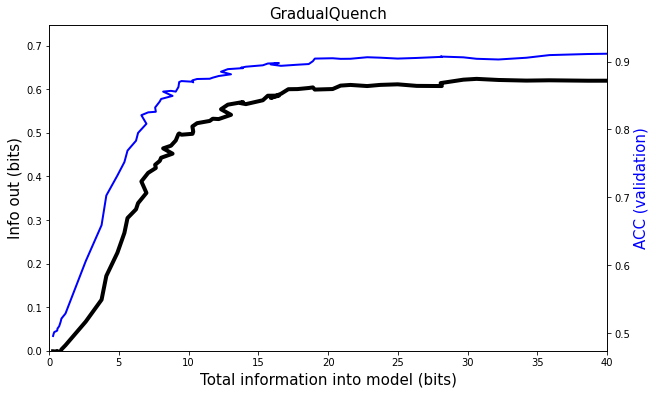

Beginning RapidQuench
Loaded train/val data.  Train array shape: (18448, 50, 12), Val: (1908, 50, 12)
Step: 0, acc : 0.4979
Step: 125, acc : 0.4927
Step: 250, acc : 0.4969
Step: 375, acc : 0.5000
Step: 500, acc : 0.5183
Step: 625, acc : 0.5058
Step: 750, acc : 0.5136
Step: 875, acc : 0.5115
Step: 1000, acc : 0.5246
Step: 1125, acc : 0.5634
Step: 1250, acc : 0.5236
Step: 1375, acc : 0.5613
Step: 1500, acc : 0.5519
Step: 1625, acc : 0.5367
Step: 1750, acc : 0.5702
Step: 1875, acc : 0.5949
Step: 2000, acc : 0.6164
Step: 2125, acc : 0.7563
Step: 2250, acc : 0.8160
Step: 2375, acc : 0.8050
Step: 2500, acc : 0.8360
Step: 2625, acc : 0.8265
Step: 2750, acc : 0.8475
Step: 2875, acc : 0.8553
Step: 3000, acc : 0.8679
Step: 3125, acc : 0.8412
Step: 3250, acc : 0.8564
Step: 3375, acc : 0.8522
Step: 3500, acc : 0.8580
Step: 3625, acc : 0.8690
Step: 3750, acc : 0.8695
Step: 3875, acc : 0.8553
Step: 4000, acc : 0.8658
Step: 4125, acc : 0.8679
Step: 4250, acc : 0.8643
Step: 4375, acc : 0.8684
Step: 45

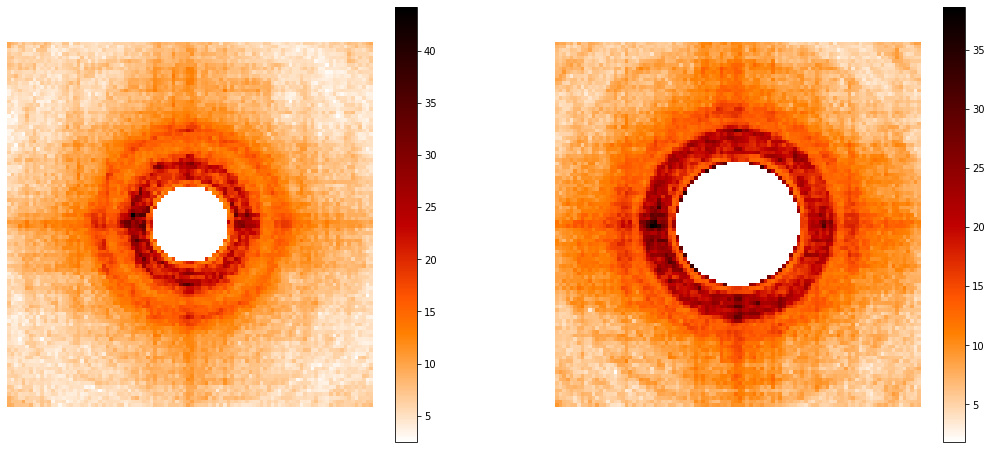

Step: 7125, acc : 0.8789
Step: 7250, acc : 0.8700
Step: 7375, acc : 0.8705
Step: 7500, acc : 0.8810
Step: 7625, acc : 0.8784
Step: 7750, acc : 0.8805
Step: 7875, acc : 0.8716
Step: 8000, acc : 0.8721


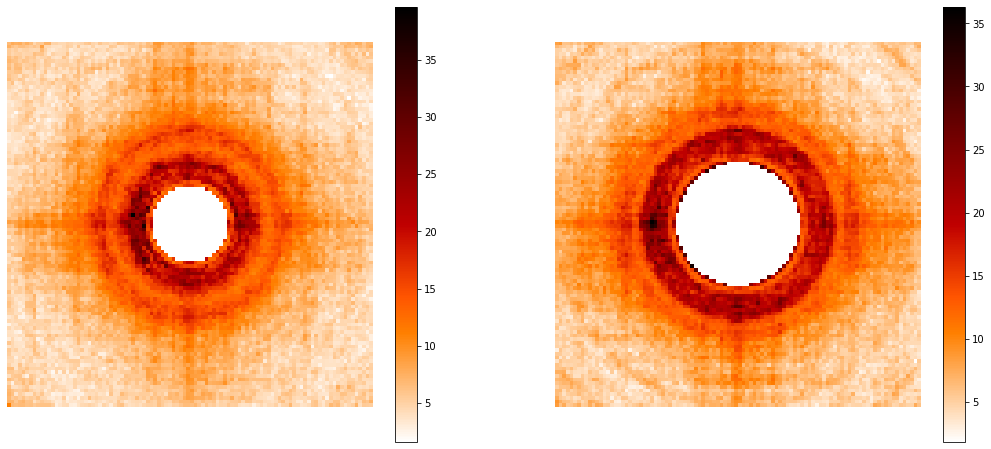

Step: 8125, acc : 0.8789
Step: 8250, acc : 0.8632
Step: 8375, acc : 0.8758
Step: 8500, acc : 0.8842
Step: 8625, acc : 0.8716
Step: 8750, acc : 0.8679
Step: 8875, acc : 0.8768
Step: 9000, acc : 0.8784


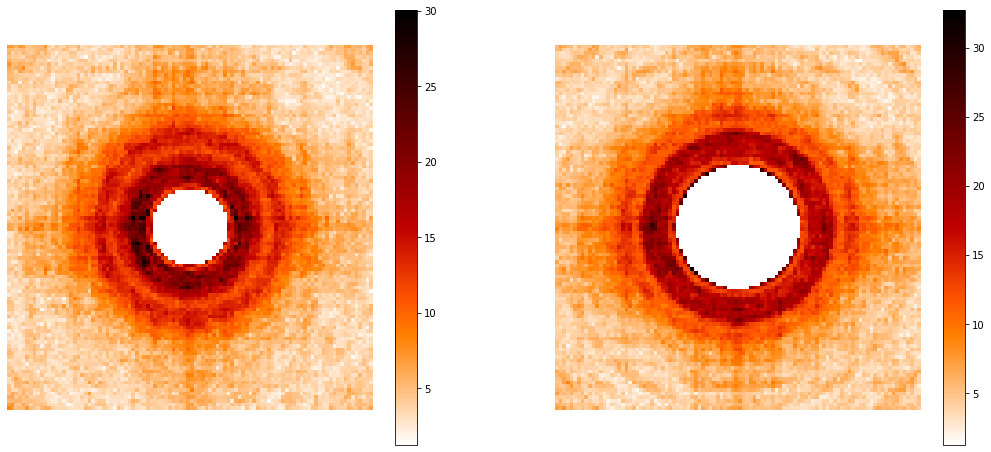

Step: 9125, acc : 0.8831
Step: 9250, acc : 0.8737
Step: 9375, acc : 0.8674
Step: 9500, acc : 0.8789
Step: 9625, acc : 0.8721
Step: 9750, acc : 0.8774
Step: 9875, acc : 0.8674
Step: 10000, acc : 0.8784


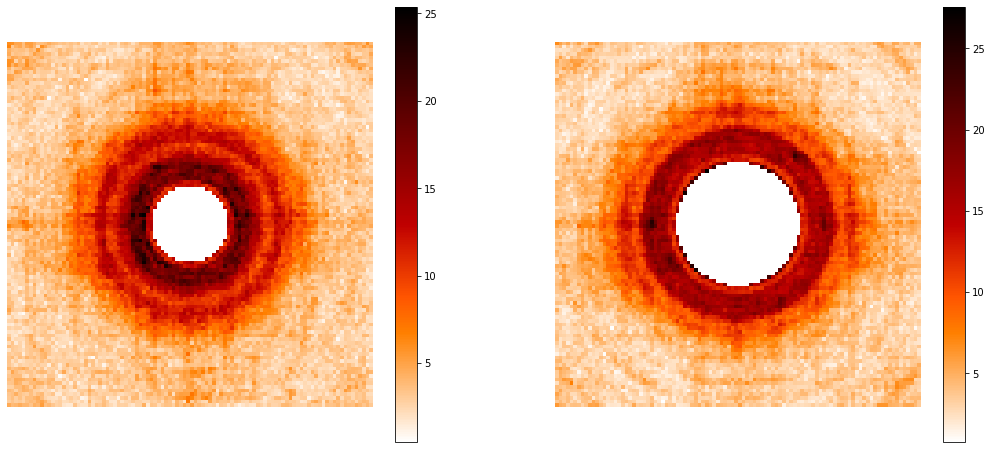

Step: 10125, acc : 0.8658
Step: 10250, acc : 0.8732
Step: 10375, acc : 0.8705
Step: 10500, acc : 0.8648
Step: 10625, acc : 0.8684
Step: 10750, acc : 0.8653
Step: 10875, acc : 0.8716
Step: 11000, acc : 0.8726


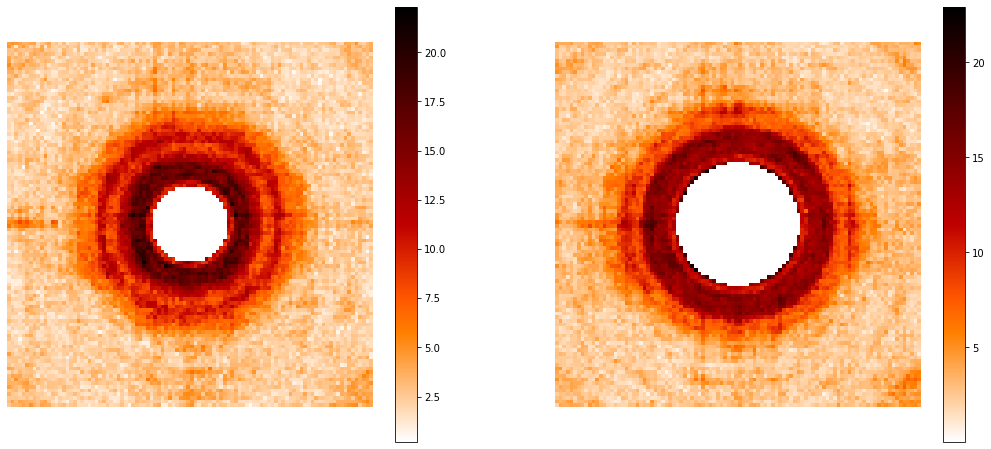

Step: 11125, acc : 0.8653
Step: 11250, acc : 0.8658
Step: 11375, acc : 0.8679
Step: 11500, acc : 0.8721
Step: 11625, acc : 0.8559
Step: 11750, acc : 0.8527
Step: 11875, acc : 0.8616
Step: 12000, acc : 0.8611


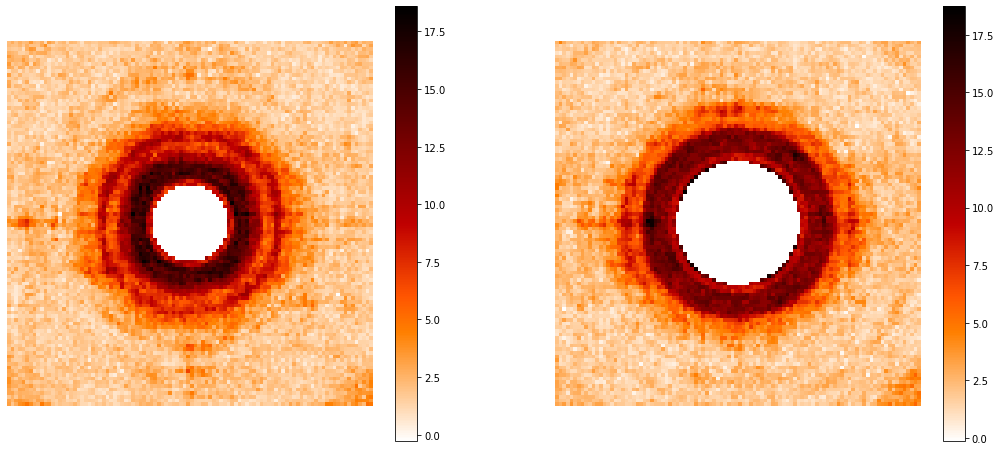

Step: 12125, acc : 0.8590
Step: 12250, acc : 0.8695
Step: 12375, acc : 0.8538
Step: 12500, acc : 0.8585
Step: 12625, acc : 0.8580
Step: 12750, acc : 0.8585
Step: 12875, acc : 0.8674
Step: 13000, acc : 0.8553


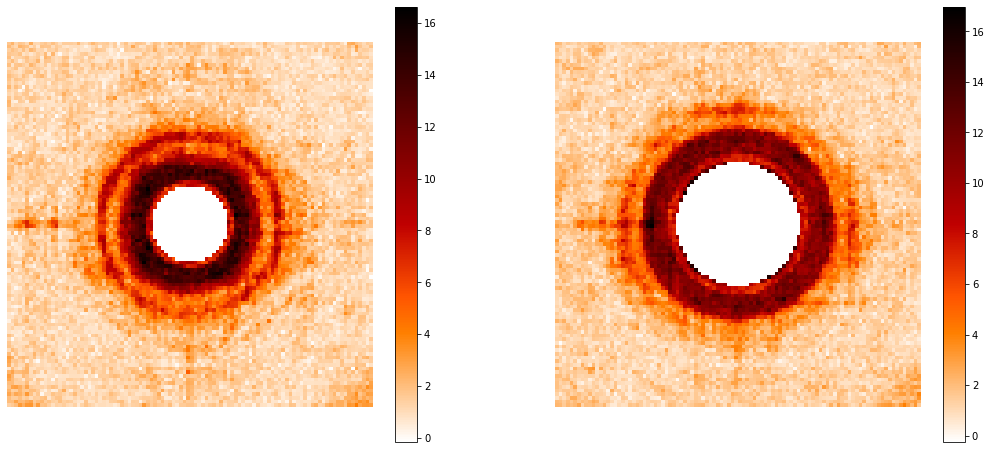

Step: 13125, acc : 0.8553
Step: 13250, acc : 0.8585
Step: 13375, acc : 0.8559
Step: 13500, acc : 0.8684
Step: 13625, acc : 0.8627
Step: 13750, acc : 0.8538
Step: 13875, acc : 0.8496
Step: 14000, acc : 0.8480


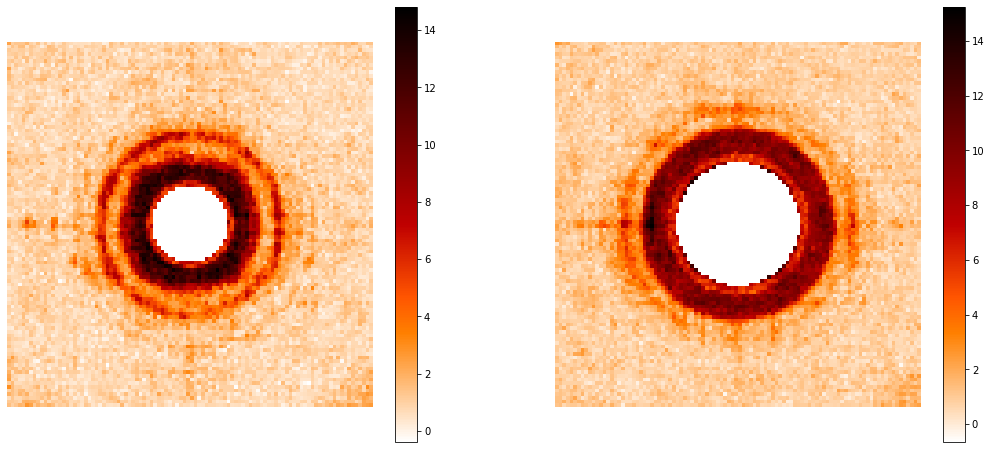

Step: 14125, acc : 0.8580
Step: 14250, acc : 0.8454
Step: 14375, acc : 0.8595
Step: 14500, acc : 0.8417
Step: 14625, acc : 0.8349
Step: 14750, acc : 0.8512
Step: 14875, acc : 0.8381
Step: 15000, acc : 0.8349


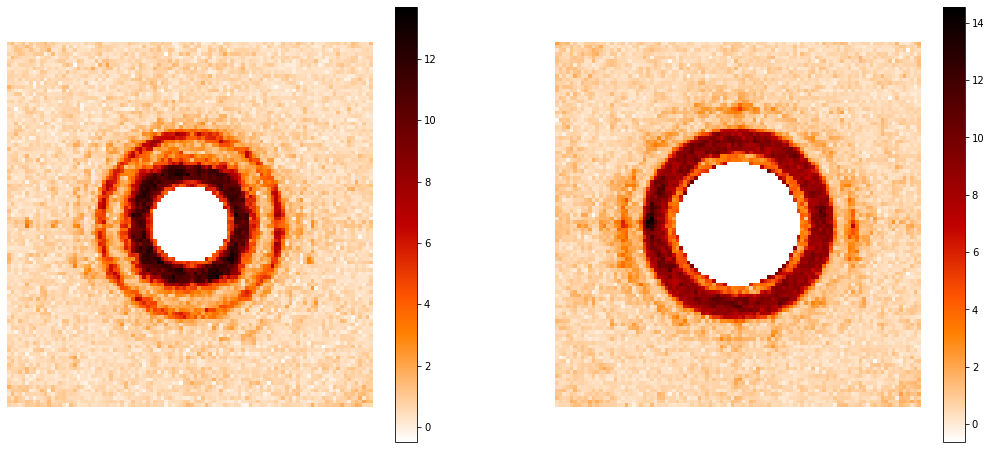

Step: 15125, acc : 0.8370
Step: 15250, acc : 0.8381
Step: 15375, acc : 0.8229
Step: 15500, acc : 0.8485
Step: 15625, acc : 0.8354
Step: 15750, acc : 0.8386
Step: 15875, acc : 0.8396
Step: 16000, acc : 0.8307


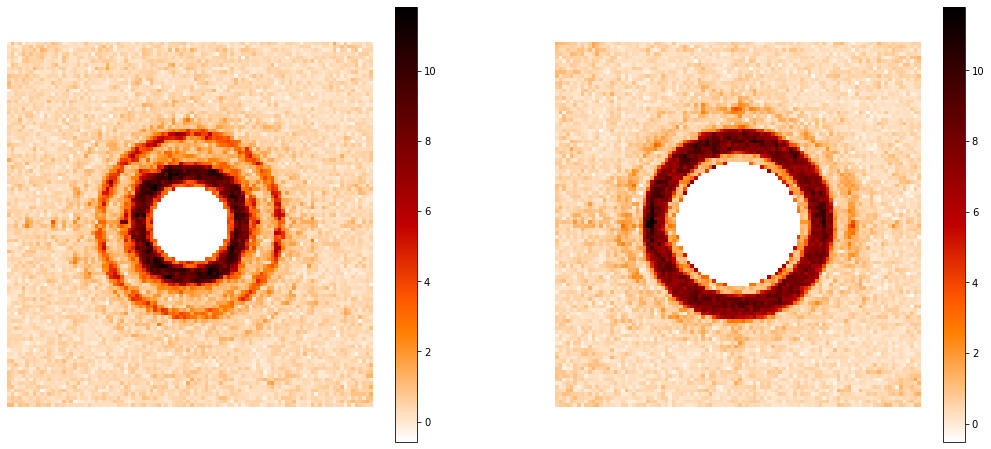

Step: 16125, acc : 0.8276
Step: 16250, acc : 0.8270
Step: 16375, acc : 0.8270
Step: 16500, acc : 0.8255
Step: 16625, acc : 0.8145
Step: 16750, acc : 0.8239
Step: 16875, acc : 0.8339
Step: 17000, acc : 0.8187


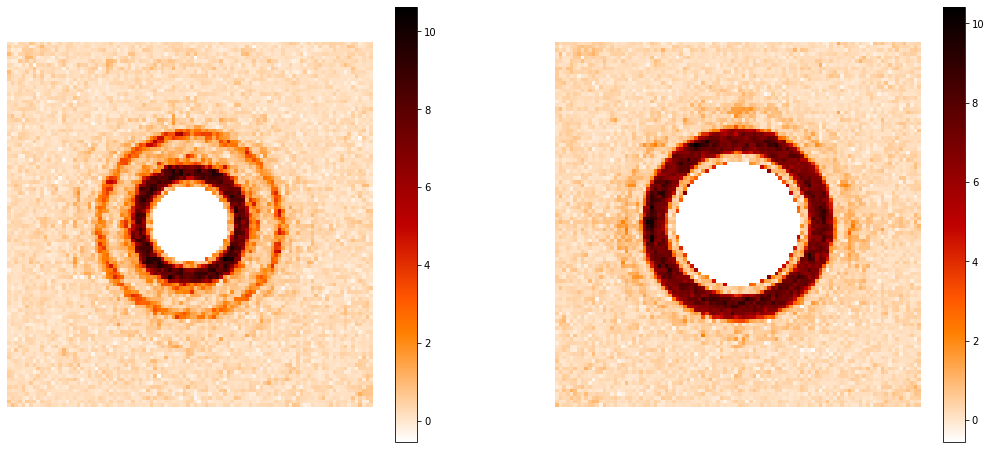

Step: 17125, acc : 0.8218
Step: 17250, acc : 0.8239
Step: 17375, acc : 0.8145
Step: 17500, acc : 0.8197
Step: 17625, acc : 0.8160
Step: 17750, acc : 0.8244
Step: 17875, acc : 0.8134
Step: 18000, acc : 0.8150


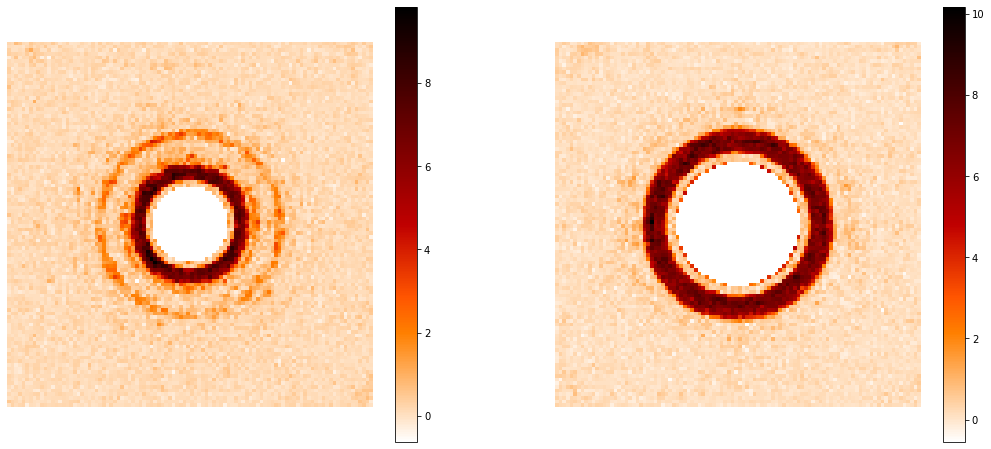

Step: 18125, acc : 0.8087
Step: 18250, acc : 0.8061
Step: 18375, acc : 0.8139
Step: 18500, acc : 0.8097
Step: 18625, acc : 0.8139
Step: 18750, acc : 0.8061
Step: 18875, acc : 0.8066
Step: 19000, acc : 0.8197


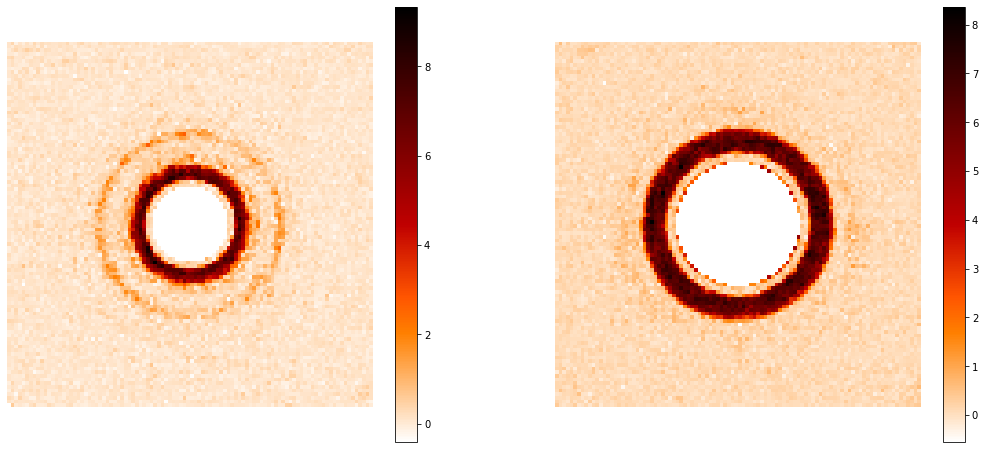

Step: 19125, acc : 0.8087
Step: 19250, acc : 0.8045
Step: 19375, acc : 0.8118
Step: 19500, acc : 0.8103
Step: 19625, acc : 0.7987
Step: 19750, acc : 0.7951
Step: 19875, acc : 0.8008
Step: 20000, acc : 0.7804


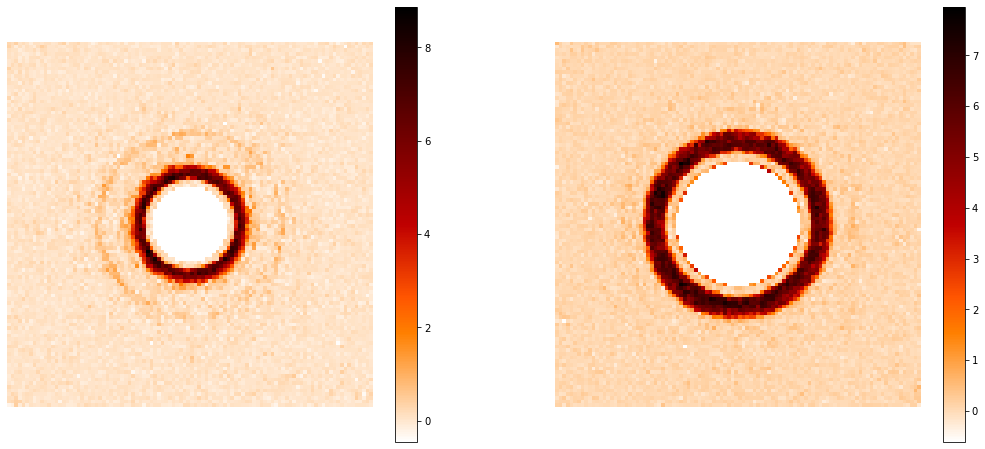

Step: 20125, acc : 0.7888
Step: 20250, acc : 0.8003
Step: 20375, acc : 0.8045
Step: 20500, acc : 0.7830
Step: 20625, acc : 0.7783
Step: 20750, acc : 0.7573
Step: 20875, acc : 0.7762
Step: 21000, acc : 0.7731


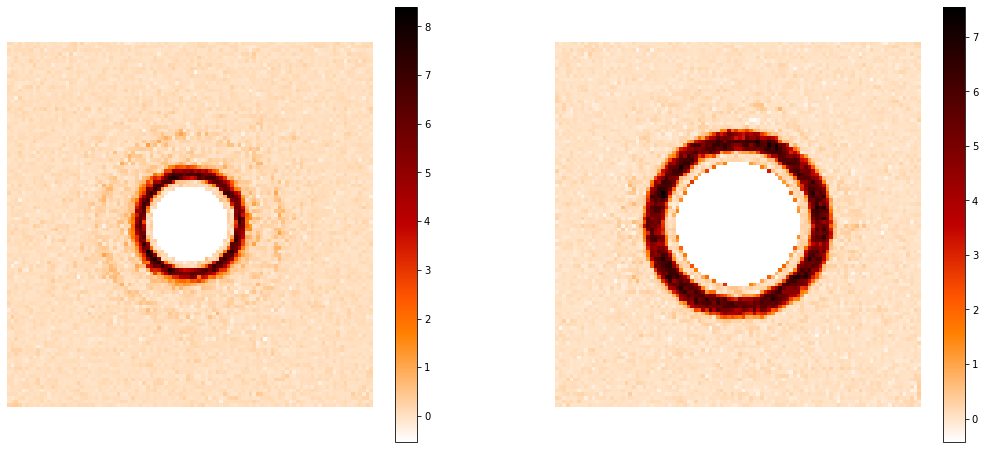

Step: 21125, acc : 0.7563
Step: 21250, acc : 0.7657
Step: 21375, acc : 0.7600
Step: 21500, acc : 0.7563
Step: 21625, acc : 0.7317
Step: 21750, acc : 0.7364
Step: 21875, acc : 0.7327
Step: 22000, acc : 0.7254


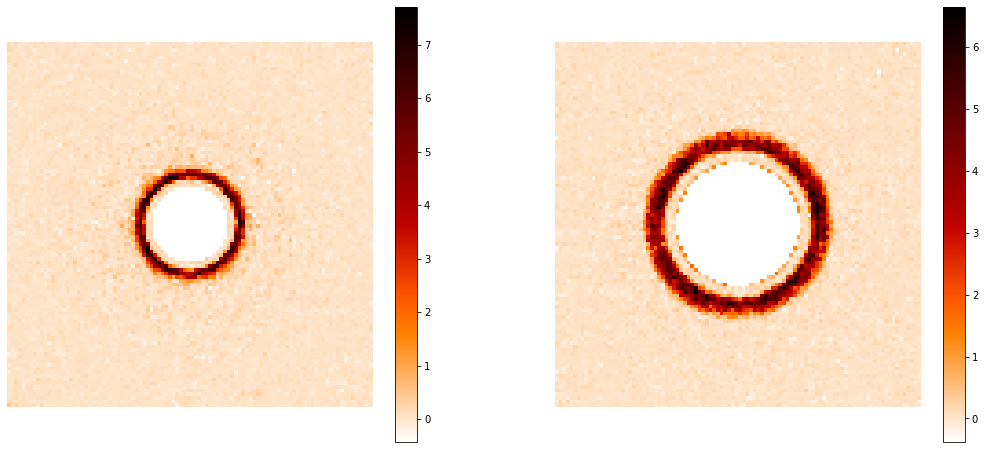

Step: 22125, acc : 0.6986
Step: 22250, acc : 0.6672
Step: 22375, acc : 0.6661
Step: 22500, acc : 0.5681
Step: 22625, acc : 0.5508
Step: 22750, acc : 0.5084
Step: 22875, acc : 0.4974
Step: 23000, acc : 0.5100


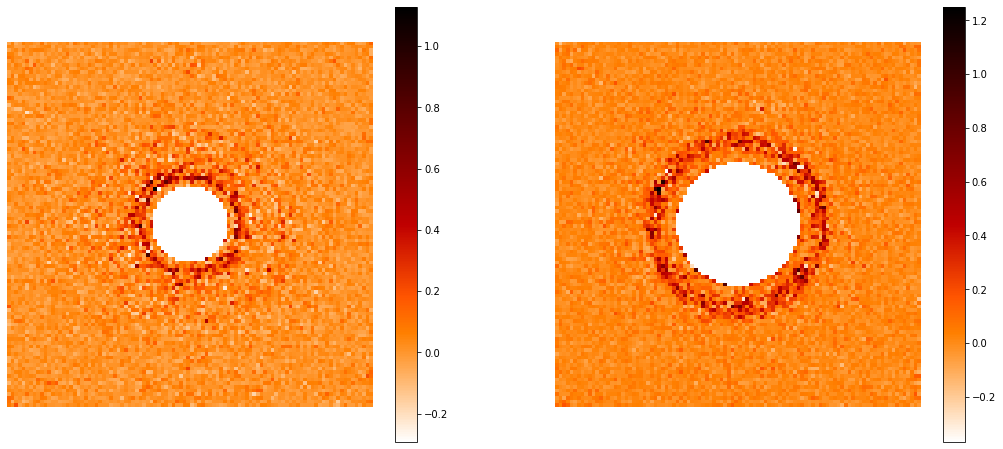

Step: 23125, acc : 0.5094
Step: 23250, acc : 0.5079
Step: 23375, acc : 0.5115
Step: 23500, acc : 0.5142
Step: 23625, acc : 0.5000
Step: 23750, acc : 0.5063
Step: 23875, acc : 0.4995
Step: 24000, acc : 0.5089


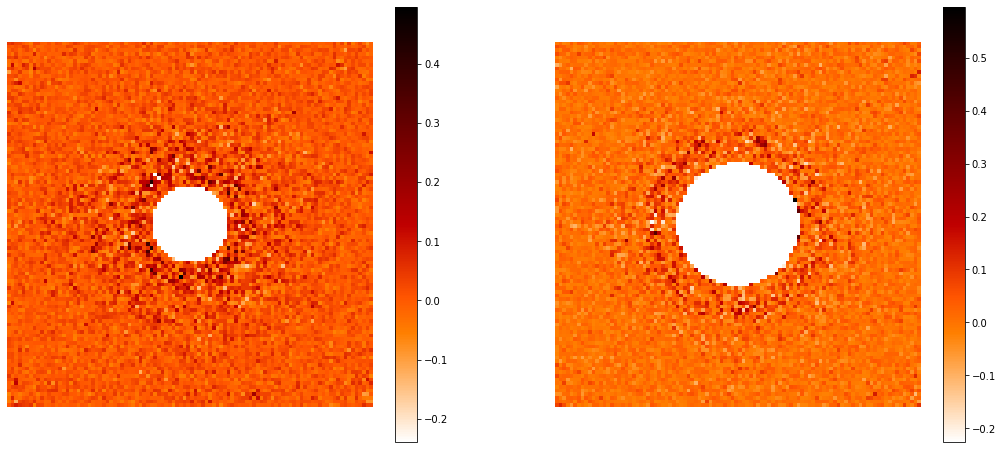

Step: 24125, acc : 0.4990
Step: 24250, acc : 0.5047
Step: 24375, acc : 0.5010
Step: 24500, acc : 0.5026
Step: 24625, acc : 0.4942
Step: 24750, acc : 0.5000
Step: 24875, acc : 0.5000
Finished training.


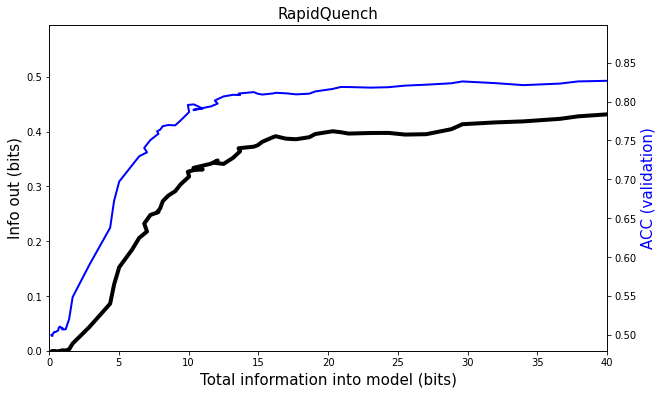

In [ ]:
# If you'd like the arrays and plots to be saved, switch to True
save_outputs = False
for protocol in ['GradualQuench', 'RapidQuench']:
  print('Beginning', protocol)

  ##############################################################################
  ### Load the data and preprocess into lists of per-particle features
  ##############################################################################
  # The data consists of neighborhoods of particles that are either about to
  # kick off a rearrangement event, or not
  pkl_dict = np.load(os.path.join(data_dir, f'{protocol}.npz'), allow_pickle=True)
  train_particle_positions = pkl_dict['train_particle_positions']
  train_types = pkl_dict['train_types']
  train_is_loci = pkl_dict['train_is_loci']
  val_particle_positions = pkl_dict['val_particle_positions']
  val_types = pkl_dict['val_types']
  val_is_loci = pkl_dict['val_is_loci']

  # The neighborhoods are different numbers of particles
  # The set transformer would be absolutely fine with this, but for ease of batching
  # we clip every neighborhood to the nearest 50 particles
  number_particles_to_use = 50  ## per neighborhood, each encoded and then input to the transformer

  particle_features_train = []
  for train_ind in range(train_types.shape[0]):
    particle_features_train.append(convert_to_per_particle_feature_set(train_particle_positions[train_ind],
                                                                       train_types[train_ind],
                                                                       number_particles_to_use=number_particles_to_use))
  particle_features_val = []
  for val_ind in range(val_types.shape[0]):
    particle_features_val.append(convert_to_per_particle_feature_set(val_particle_positions[val_ind],
                                                                     val_types[val_ind],
                                                                     number_particles_to_use=number_particles_to_use))

  particle_features_train = np.stack(particle_features_train)
  particle_features_val = np.stack(particle_features_val)

  loci_train = np.squeeze(np.concatenate(train_is_loci)).reshape([-1, 1])
  loci_val = np.squeeze(np.concatenate(val_is_loci)).reshape([-1, 1])

  print(f'Loaded train/val data.  Train array shape: {particle_features_train.shape}, Val: {particle_features_val.shape}')
  ##############################################################################
  ### Create the particle encoder and the set transformer
  ##############################################################################
  # The particle encoder is an MLP that turns every particle into a compressed
  # representation
  particle_encoder_arch_spec = [128]*2
  number_positional_encoding_frequencies = 5
  positional_encoding_frequencies = 2**np.arange(1, number_positional_encoding_frequencies)
  activation_layer = tf.keras.layers.LeakyReLU(0.1)

  bottleneck_dimension = 32
  # With the positional encoding and the extra preprocessing, we're puffing out
  # the low dimensional position vector to a higher dimensional input that has
  # more footholds for the MLP to latch onto
  particle_feature_dimensions = 2 + 2 + 2 + 2 + 2 + 2  # All the stuff from convert_to_per_particle_feature_set

  # Now make a single particle encoder that will do all of the compression
  layers = [tf.keras.Input((None, particle_feature_dimensions))]
  layers += [PositionalEncoding(positional_encoding_frequencies)]
  for number_units in particle_encoder_arch_spec:
    layers += [tf.keras.layers.Dense(number_units, activation_layer)]
  layers += [tf.keras.layers.Dense(bottleneck_dimension*2)]
  particle_encoder = tf.keras.Sequential(layers)

  # The set transformer takes a set of compressed representations that lack a
  # sense of ordering, and processes the set to a single representation
  # The architecture is from Lee et al., 2019
  key_dim = 128
  number_heads_per_mha = 12
  number_attention_blocks = 6
  final_pooling = 'mean'
  ff_arch_per_block = [128]*1 + [bottleneck_dimension]
  ff_activation_function = 'relu'

  final_processing_arch = [256]*1
  final_processing_activation_function = tf.keras.layers.LeakyReLU(0.1)

  output_dimensionality = 1

  inp = tf.keras.Input((number_particles_to_use, bottleneck_dimension))
  x = inp
  for block_num in range(number_attention_blocks):
    attn_result = tf.keras.layers.MultiHeadAttention(number_heads_per_mha,
                                                     key_dim)(x, x, x)
    partial1 = tf.keras.layers.Add()([x, attn_result])
    H = tf.keras.layers.LayerNormalization()(partial1)

    processing_ff_net = tf.keras.Sequential([tf.keras.layers.Dense(number_units, ff_activation_function) for number_units in ff_arch_per_block])
    H_ff = processing_ff_net(H)
    partial2 = tf.keras.layers.Add()([H, H_ff])
    x = tf.keras.layers.LayerNormalization()(partial2)

  # Reduce the set of representations down to a single one
  x = tf.reduce_mean(x, axis=-2)

  final_processing_net = tf.keras.Sequential([tf.keras.layers.Dense(number_units, final_processing_activation_function) for number_units in final_processing_arch])
  x = final_processing_net(x)
  x = tf.keras.layers.Dense(output_dimensionality)(x)

  set_transformer = tf.keras.Model(inp, x)

  # The trainable variables are from these two models
  all_trainable_variables = particle_encoder.trainable_variables + set_transformer.trainable_variables

  ##############################################################################
  ### Training parameters
  ##############################################################################
  number_training_steps = 25_000

  learning_rate = 1e-4
  number_linear_ramp_lr_steps = number_training_steps // 10
  optimizer = tf.keras.optimizers.Adam(learning_rate)

  beta_start = 2e-6
  beta_end = 2e-1
  beta_var = tf.Variable(beta_start, trainable=False)

  batch_size = 32  ## neighborhoods, and each has 50 particles

  ## For computing the total information
  eval_every = number_training_steps // 200
  eval_start = number_training_steps // 4
  eval_batch_size = 32  # this grabs 32 neighborhoods, so it's really 32 x 50 particle encodings
  num_eval_batches = 16

  ## For computing the per-particle information in the channel, along a grid
  eval_grid_mi_every = 1000
  eval_batch_size_probe_grid = 512  # This is per probe point, and can be larger because it's not evaluating the full cross distance matrix

  bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
  logvar_initialization = -3.  # We found it helpful to start the variances of the particles much less than 1
  @tf.function()
  def train_step(batch_inp, is_loci, training=True):
    with tf.GradientTape() as tape:
      embs_mus, embs_logvars = tf.split(particle_encoder(batch_inp), 2, axis=-1)
      embs_logvars = embs_logvars + logvar_initialization  # This helps initialize the logvars small enough for particles to be easily discernible
      embs_reparam = tf.random.normal(tf.shape(embs_mus), mean=embs_mus, stddev=tf.exp(embs_logvars/2.))
      kl = tf.reduce_mean(tf.reduce_sum(0.5 * (tf.square(embs_mus) + tf.exp(embs_logvars) - embs_logvars - 1.), axis=(-1, -2)))  ## sum over dimension and particles, avg over batch
      loci_prediction = set_transformer(embs_reparam)
      bce_losses = tf.reduce_mean(bce(is_loci, loci_prediction))
      loss = bce_losses + beta_var * kl
    if training:
      grads = tape.gradient(loss, all_trainable_variables)
      optimizer.apply_gradients(zip(grads, all_trainable_variables))
    return bce_losses

  ##############################################################################
  ### Setup for displaying the per-particle information map
  ##############################################################################
  # Create a grid of probe particles to insert into batches of real data
  # and estimate the information transmitted as if a particle were at the probe
  # point.
  grid_bound = 3  # in simulation units, roughly the radius of type A plus the radius of type B
  grid_side_length = 100  # number of evaluation points, so this will produce a 10k-point grid
  xx, yy = np.meshgrid(np.linspace(-grid_bound, grid_bound, grid_side_length),
                      np.linspace(-grid_bound, grid_bound, grid_side_length))
  particle_positions_probe = np.stack([xx, yy], -1).reshape([-1, 2]).astype(np.float32)

  # Black out the center region where there are no particles, because the
  # network outputs there are meaningless
  average_density_threshold_for_display = 1e-6

  g_r_AA = np.load(os.path.join(data_dir, f'g_r_AA_{protocol}.npy'))
  g_r_AB = np.load(os.path.join(data_dir, f'g_r_AB_{protocol}.npy'))
  g_r_bins = np.load(os.path.join(data_dir, 'g_r_bins.npy'))

  radius_cutoffA = np.where(g_r_AA<average_density_threshold_for_display)[0][-1]
  radius_cutoffB = np.where(g_r_AB<average_density_threshold_for_display)[0][-1]

  maskA = np.reshape(np.where(np.hypot(*particle_positions_probe.T)<g_r_bins[radius_cutoffA],
                              np.nan, 1.), [grid_side_length, grid_side_length])
  maskB = np.reshape(np.where(np.hypot(*particle_positions_probe.T)<g_r_bins[radius_cutoffB],
                              np.nan, 1.), [grid_side_length, grid_side_length])
  masks = [maskA, maskB]
  ##############################################################################

  bce_series_val, acc_series_val, info_bounds = [[] for _ in range(3)]

  for step in range(number_training_steps):
    # Ramp the learning rate
    tf.keras.backend.set_value(optimizer.learning_rate,
                                min(step/number_linear_ramp_lr_steps, 1)*learning_rate)
    # Anneal beta
    beta_var.assign(np.exp(np.log(beta_start)+float(step)/number_training_steps*(np.log(beta_end)-np.log(beta_start))))
    # Select a random subset of neighborhoods
    batch_inds = np.random.choice(particle_features_train.shape[0], size=batch_size, replace=True)
    # Train
    train_step(particle_features_train[batch_inds], loci_train[batch_inds])


    ############################################################################
    ### Evaluate the info out, accuracy
    ############################################################################
    if (step % eval_every == 0):
      predictions, loci, bce_val = [[] for _ in range(3)]
      for batch_start in range(0, particle_features_val.shape[0], batch_size):
        batch_inds = np.arange(batch_start, min(particle_features_val.shape[0], batch_start+batch_size))
        batch_particles = particle_features_val[batch_inds]
        batch_is_loci = loci_val[batch_inds]
        loss_bce = train_step(batch_particles, batch_is_loci, training=False)
        embs_mus, embs_logvars = tf.split(particle_encoder(batch_particles), 2, axis=-1)
        loci_prediction_sampled = set_transformer(tf.random.normal(tf.shape(embs_mus), mean=embs_mus, stddev=tf.exp((embs_logvars+logvar_initialization)/2.)))
        predictions.append(np.sign(loci_prediction_sampled))
        loci.append(batch_is_loci)
        bce_val.append(loss_bce)
      loci = np.concatenate(loci)
      predictions = np.concatenate(predictions)
      acc = np.average(predictions == (loci*2-1))
      acc_series_val.append(acc)
      bce_series_val.append(np.mean(bce_val))
      print(f'Step: {step}, acc : {acc:.4f}')

      ##########################################################################
      ### Evaluate I(U;X)
      ##########################################################################
      if (step >= eval_start):
        lower_bounds, upper_bounds = [[], []]
        for _ in range(num_eval_batches):
          batch_inds = np.random.choice(particle_features_val.shape[0], size=eval_batch_size)
          batch_particles = particle_features_val[batch_inds]
          batch_particles = tf.reshape(batch_particles, [-1, particle_feature_dimensions])
          casting_dimension = tf.shape(batch_particles)[0]
          embs_mus, embs_logvars = tf.split(particle_encoder(batch_particles), 2, axis=-1)
          mus = tf.cast(embs_mus, tf.float64)
          logvars = tf.cast(embs_logvars, tf.float64)
          logvars = logvars + logvar_initialization
          lower, upper = compute_infos_mus_logvars(mus, logvars)
          lower_bounds.append(lower)
          upper_bounds.append(upper)

        info_bounds.append([number_particles_to_use*np.mean(lower_bounds), number_particles_to_use*np.mean(upper_bounds)])

      # Now use probe points along with a bunch of real points to get the info for points on a grid
      ## We don't evaluate the full N x N conditional distribution matrix -- we instead evaluate the M x N conditional -- M is the number of probe points, and N is the number of data samples
      if step % eval_grid_mi_every == 0 and (step >= eval_start):
        info_cmap = 'gist_heat_r'
        number_probes_to_eval_at_a_time = 100

        plt.figure(figsize=(18, 8))
        for type_id in range(2):
          types = (type_id+1) * np.ones(grid_side_length**2).astype(np.float32)
          features = convert_to_per_particle_feature_set(particle_positions_probe, types, number_particles_to_use=-1)
          embs_mus_probes, embs_logvars_probes = tf.split(particle_encoder(features), 2, axis=-1)
          embs_logvars_probes = embs_logvars_probes - 3
          mus_probes = tf.cast(embs_mus_probes, tf.float64)
          logvars_probes = tf.cast(embs_logvars_probes, tf.float64)
          stddevs_probes = tf.exp(logvars_probes/2.)

          probe_lower_bounds, probe_upper_bounds = [[], []]
          for probe_ind_start in range(0, grid_side_length**2, number_probes_to_eval_at_a_time):
            probe_ind_end = min(grid_side_length**2, probe_ind_start+number_probes_to_eval_at_a_time)

            lower_bounds_per, upper_bounds_per = [[], []]
            for _ in range(num_eval_batches):
              batch_inds = np.random.choice(particle_features_val.shape[0], size=eval_batch_size_probe_grid, replace=True)
              batch_particles = particle_features_val[batch_inds]
              batch_particles = tf.reshape(batch_particles, [-1, particle_feature_dimensions])  ## Use both types of particles for these samples
              casting_dimension = tf.shape(batch_particles)[0]
              embs_mus_data, embs_logvars_data = tf.split(particle_encoder(batch_particles), 2, axis=-1)
              mus_data = tf.cast(embs_mus_data, tf.float64)
              logvars_data = tf.cast(embs_logvars_data, tf.float64)
              logvars_data = logvars_data - 3.
              embedding_dimension = tf.shape(mus_data)[-1]
              normalization_factor = (2.*np.pi)**(tf.cast(embedding_dimension, tf.float64)/2.)

              stddevs_data = tf.exp(logvars_data/2.)

              sampled_u_probes = tf.random.normal(mus_probes[probe_ind_start:probe_ind_end].shape, mean=mus_probes[probe_ind_start:probe_ind_end], stddev=stddevs_probes[probe_ind_start:probe_ind_end], dtype=tf.float64)
              u_mu_dists_probes = sampled_u_probes - mus_probes[probe_ind_start:probe_ind_end]  ## shape [M, d]
              u_mu_norm_dists_probes = u_mu_dists_probes / stddevs_probes[probe_ind_start:probe_ind_end]
              p_ui_xi_probes = tf.exp(-tf.reduce_sum(u_mu_norm_dists_probes**2, axis=-1)/2. - tf.reduce_sum(logvars_probes[probe_ind_start:probe_ind_end], axis=-1)/2.)/normalization_factor  ## shape [M]

              ## Now eval the conditional dists from the data x_j
              u_mu_dists_probes_to_data = tf.reshape(sampled_u_probes, [-1, 1, embedding_dimension]) - tf.reshape(mus_data, [1, -1, embedding_dimension])  ## shape [NM, N], with the first index i for the particular y across the rest of the batch
              u_mu_norm_dists_probes_to_data = u_mu_dists_probes_to_data / tf.reshape(stddevs_data, [1, -1, embedding_dimension])
              ## Take the product over the last axis, but we can add these first and then exp
              p_u_x_conditional_pdfs = tf.exp(-tf.reduce_sum(u_mu_norm_dists_probes_to_data**2, axis=-1)/2. - tf.reshape(tf.reduce_sum(logvars_data, axis=-1), [1, -1])/2.)/normalization_factor

              ## The first index is by u, and everything in that row is p(u_i|x_j)
              infonce_per = tf.math.log(p_ui_xi_probes/tf.reduce_mean(tf.concat([tf.expand_dims(p_ui_xi_probes, 1), p_u_x_conditional_pdfs], axis=-1), axis=1))  ## [M] / mean of [M, N+1] along N+1
              lower_bounds_per.append(infonce_per)
              # Now set do the log ratio without including the probe conditional in the denominator
              loo_per = tf.math.log(p_ui_xi_probes/tf.reduce_mean(p_u_x_conditional_pdfs, axis=1))  ## [M] / mean of [M, N] along N
              upper_bounds_per.append(loo_per)
            lower_bounds_per = np.stack(lower_bounds_per, 0)  ## These are now per probe
            upper_bounds_per = np.stack(upper_bounds_per, 0)
            probe_lower_bounds.append(np.mean(lower_bounds_per, axis=0))
            probe_upper_bounds.append(np.mean(upper_bounds_per, axis=0))
          info_bounds_grid = np.stack([probe_lower_bounds, probe_upper_bounds], -1).reshape([grid_side_length, grid_side_length, 2])
          if save_outputs:
            np.save(f'info_bounds_grid_{step}_type{type_id}.npy', info_bounds_grid)
          plt.subplot(1, 2, type_id+1)
          plt.imshow(masks[type_id]*np.mean(info_bounds_grid, axis=-1)/np.log(2), info_cmap)
          plt.axis('off')
          plt.colorbar()
        if save_outputs:
          plt.savefig(f'infomap_{step}.svg')
        plt.show()

  print('Finished training.')
  ##########################################################################
  ### Plot the distributed info plane
  ##########################################################################
  info_in_plot_lims = [0, 40]

  bce_series_val = np.float32(bce_series_val) / np.log(2)
  acc_series_val = np.float32(acc_series_val)
  info_bounds = np.float32(info_bounds)/np.log(2)
  if save_outputs:
    np.savez('history.npz',
        validation_bce=bce_series_val,
        acc_validation=acc_series_val,
        info_bounds=info_bounds)

  info_in_full = np.mean(info_bounds, axis=-1)  ## already upscaled by the number of particles per neighborhood

  smoothing_sigma = 1
  bce_series_val = nim.filters.gaussian_filter1d(bce_series_val, smoothing_sigma)
  acc_series_val = nim.filters.gaussian_filter1d(acc_series_val, smoothing_sigma)

  plotting_start_ind = -len(info_in_full)
  entropy_y = 1.
  info_out = entropy_y - bce_series_val[plotting_start_ind:]

  plt.figure(figsize=(10, 6))
  ax = plt.gca()
  ax.plot(info_in_full, info_out, lw=4, color='k')
  ax.set_ylim(0, None)
  ax.set_xlim(info_in_plot_lims)
  ax.set_xlabel("Total information into model (bits)", fontsize=15)
  ax.set_ylabel("Info out (bits)", fontsize=15)

  ax2 = ax.twinx()

  ax2.plot(info_in_full, acc_series_val[plotting_start_ind:], lw=2, color='b')
  ax2.set_ylabel('ACC (validation)', color='b', fontsize=15)
  if save_outputs:
    plt.savefig(os.path.join(expt_outdir, 'infoplane.png'))
  plt.title(protocol, fontsize=15)
  plt.show()